# [Going Deeper NLP 04] DTM, TF-IDF Vocabulary Size실험 

Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 패키지인 SentencePiece를 사용하는 프로젝트입니다. 

---

## 프로젝트 목표
---
- vocabulary size에 따른 모델 성능 비교
- reuters 뉴스 데이터를 이용해 뉴스 카테고리 다중분류를 한다. 

## 프로젝트 설명
---
1. reuters 뉴스 데이터를 불러온다. (이 때 단어의 수를 조절할 수 있다.) 
    - 전체 단어
    - 5000개 단어
    - 그 외로 실험해보기(3가지)
2. 머신러닝 모델 학습
    - 나이브 베이즈 분류기
    - CNB
    - 로지스틱 회귀
    - 서포트 벡터 머신(SVM)
    - 결정 트리
    - 랜덤 포레스트
    - 그래디언트 부스팅 트리
    - 보팅 
    
## 0. 모듈 Import

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 데이터 불러오기 및 분석, 전처리 

### (1) 모든 단어 사용 
- 실험을 위해 데이터셋의 모든 단어를 사용한다.
- 해당 데이터셋은 정수 시퀀스로 변환되어 제공된다. 

In [18]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [19]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [21]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


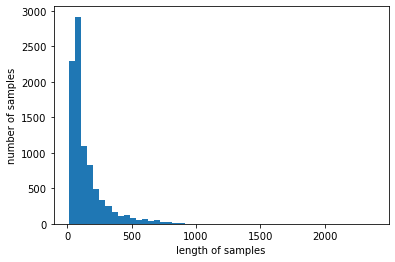

In [22]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

- 0, 1, 2번에 \<pad>, \<sos>, \<unk> 토큰이 매핑되어있다.    
- 이를 위해 index에 3을 더해주는 추가 작업이 필요함

In [24]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [25]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

- 0번째 샘플로 확인

In [26]:
x_train[0]

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [27]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


- 전체 데이터 변환(train, test)

In [28]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [29]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

## 2. 벡터화 하기
- Document Term Matrix, DTM을 활용한 TF-IDF행렬로 벡터화한다.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

- DTM 생성

In [31]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


- TF-IDF 생성

In [32]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 3. 머신러닝 모델 학습
- 나이브 베이즈 분류기
- Complement Naive Bayes Classifier, CNB
- 로지스틱 회귀
- 서포트 벡터 머신(SVM)
- 결정 트리
- 랜덤 포레스트
- 그래디언트 부스팅 트리
- 보팅 

In [34]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

- train데이터를 TF-IDF행렬로 변환한 것처럼 test데이터도 변환합니다.
- 정확도를 측정하기 위함 

In [38]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [42]:
def train_ml(tfidfv, y_train, tfidfv_test, y_test):
    # 나이브 베이즈 분류기 
    mod = MultinomialNB()
    mod.fit(tfidfv, y_train)
    
    mod_predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("나이브 베이즈 정확도:", accuracy_score(y_test, mod_predicted)) #예측값과 실제값 비교
    
    # CNB
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    
    cb_predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("CNB 정확도:", accuracy_score(y_test, cb_predicted)) #예측값과 실제값 비교
    
    # 로지스틱 회귀 
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)

    lr_predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("로지스틱 회귀 정확도:", accuracy_score(y_test, lr_predicted)) #예측값과 실제값 비교
    
    # 선형 서포트 벡터 머신 
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    
    lsvc_predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("SVM 정확도:", accuracy_score(y_test, lsvc_predicted)) #예측값과 실제값 비교
    
    # 결정 트리(Decision Tree) 
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    
    tree_predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("결정 트리 정확도:", accuracy_score(y_test, tree_predicted)) #예측값과 실제값 비교
    
    # 랜덤 포레스트(Random Forest)
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    
    forest_predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("랜덤 포레스트 정확도:", accuracy_score(y_test, forest_predicted)) #예측값과 실제값 비교
    
    # 그래디언트 부스팅 트리(GradientBoostingClassifier)
    grbt = GradientBoostingClassifier(random_state=0, verbose=3) # verbose=3
    grbt.fit(tfidfv, y_train)

    grbt_predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("그래디언트 부스팅 트리 정확도:", accuracy_score(y_test, grbt_predicted)) #예측값과 실제값 비교
    
    # 보팅(Voting)
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)
    
    voting_classifier_predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("보팅 정확도:", accuracy_score(y_test, voting_classifier_predicted)) #예측값과 실제값 비교
    
    return mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier

In [44]:
mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier = train_ml(tfidfv, y_train, tfidfv_test, y_test)

나이브 베이즈 정확도: 0.5997328584149599
CNB 정확도: 0.7649154051647373


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.813446126447017


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.784060552092609
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6544968833481746
그래디언트 부스팅 트리 정확도: 0.7702582368655387
보팅 정확도: 0.8187889581478184


### (2) 단어 5000개 사용 

In [45]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [46]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
    decoded.append(t)

x_train_5k = decoded

In [47]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
    decoded.append(t)

x_test_5k = decoded

- 행렬 변환

In [48]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)

(8982, 4867)


In [49]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

(8982, 4867)


In [50]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) # DTM을 TF-IDF 행렬로 변환

In [51]:
import time
start = time.time() 

mod_5k, cb_5k, lr_5k, lsvc_5k, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_ml(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

print("time :", time.time() - start)

나이브 베이즈 정확도: 0.6731967943009796
CNB 정확도: 0.7707034728406055


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8058771148708815


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7666963490650045
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.701246660730187
그래디언트 부스팅 트리 정확도: 0.767586821015138
보팅 정확도: 0.8161175422974176
time : 1338.3355541229248


### (3-1) 단어 1000개 사용

In [59]:
(x_train_1k, y_train_1k), (x_test_1k, y_test_1k) = reuters.load_data(num_words=1000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [60]:
decoded = []
for i in range(len(x_train_1k)):
    t = ' '.join([index_to_word[index] for index in x_train_1k[i]])
    decoded.append(t)

x_train_1k = decoded

In [61]:
decoded = []
for i in range(len(x_test_1k)):
    t = ' '.join([index_to_word[index] for index in x_test_1k[i]])
    decoded.append(t)

x_test_1k = decoded

- 행렬 변환

In [62]:
dtmvector = CountVectorizer()
x_train_dtm_1k = dtmvector.fit_transform(x_train_1k)
print(x_train_dtm_1k.shape)

(8982, 969)


In [63]:
tfidf_transformer = TfidfTransformer()
tfidfv_1k = tfidf_transformer.fit_transform(x_train_dtm_1k)
print(tfidfv_1k.shape)

(8982, 969)


In [64]:
x_test_dtm_1k = dtmvector.transform(x_test_1k) #테스트 데이터를 DTM으로 변환
tfidfv_test_1k = tfidf_transformer.transform(x_test_dtm_1k) #DTM을 TF-IDF 행렬로 변환

In [66]:
import time
import datetime

start = time.time() 

mod_1k, cb_1k, lr_1k, lsvc_1k, tree_1k, forest_1k, grbt_1k, voting_classifier_1k = train_ml(tfidfv_1k, y_train_1k, tfidfv_test_1k, y_test_1k)


sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6856634016028496
CNB 정확도: 0.7346393588601959


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.780053428317008


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7172751558325913
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.707479964381122
그래디언트 부스팅 트리 정확도: 0.7457702582368655
보팅 정확도: 0.7845057880676759
run time : 0:18:14


### (3-2) 단어 10000개 사용

In [67]:
(x_train_10k, y_train_10k), (x_test_10k, y_test_10k) = reuters.load_data(num_words=10000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [68]:
decoded = []
for i in range(len(x_train_10k)):
    t = ' '.join([index_to_word[index] for index in x_train_10k[i]])
    decoded.append(t)

x_train_10k = decoded

In [69]:
decoded = []
for i in range(len(x_test_10k)):
    t = ' '.join([index_to_word[index] for index in x_test_10k[i]])
    decoded.append(t)

x_test_10k = decoded

- 행렬 변환

In [70]:
dtmvector = CountVectorizer()
x_train_dtm_10k = dtmvector.fit_transform(x_train_10k)
print(x_train_dtm_10k.shape)

(8982, 9670)


In [71]:
tfidf_transformer = TfidfTransformer()
tfidfv_10k = tfidf_transformer.fit_transform(x_train_dtm_10k)
print(tfidfv_10k.shape)

(8982, 9670)


In [72]:
x_test_dtm_10k = dtmvector.transform(x_test_10k) #테스트 데이터를 DTM으로 변환
tfidfv_test_10k = tfidf_transformer.transform(x_test_dtm_10k) #DTM을 TF-IDF 행렬로 변환

In [73]:
start = time.time() 

mod_10k, cb_10k, lr_10k, lsvc_10k, tree_10k, forest_10k, grbt_10k, voting_classifier_10k = train_ml(tfidfv_10k, y_train_10k, tfidfv_test_10k, y_test_10k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6567230632235085
CNB 정확도: 0.7707034728406055


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8076580587711487


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7813891362422084
결정 트리 정확도: 0.6202137132680321
랜덤 포레스트 정확도: 0.674087266251113
그래디언트 부스팅 트리 정확도: 0.7666963490650045
보팅 정확도: 0.8116651825467498
run time : 0:22:25


### (3-3) 단어 20000개 사용

In [74]:
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [75]:
decoded = []
for i in range(len(x_train_20k)):
    t = ' '.join([index_to_word[index] for index in x_train_20k[i]])
    decoded.append(t)

x_train_20k = decoded

In [76]:
decoded = []
for i in range(len(x_test_20k)):
    t = ' '.join([index_to_word[index] for index in x_test_20k[i]])
    decoded.append(t)

x_test_20k = decoded

- 행렬 변환

In [77]:
dtmvector = CountVectorizer()
x_train_dtm_20k = dtmvector.fit_transform(x_train_20k)
print(x_train_dtm_20k.shape)

(8982, 18479)


In [78]:
tfidf_transformer = TfidfTransformer()
tfidfv_20k = tfidf_transformer.fit_transform(x_train_dtm_20k)
print(tfidfv_20k.shape)

(8982, 18479)


In [79]:
x_test_dtm_20k = dtmvector.transform(x_test_20k) #테스트 데이터를 DTM으로 변환
tfidfv_test_20k = tfidf_transformer.transform(x_test_dtm_20k) #DTM을 TF-IDF 행렬로 변환

In [ ]:
start = time.time() 

mod_20k, cb_20k, lr_20k, lsvc_20k, tree_20k, forest_20k, grbt_20k, voting_classifier_20k = train_ml(tfidfv_20k, y_train_20k, tfidfv_test_20k, y_test_20k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6193232413178985
CNB 정확도: 0.7671415850400712


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8098842386464826


# 루브릭 평가
---
1. **분류 모델의 accuracy가 기준 이상 높게 나왔는가?**   

    - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.  


2. **분류 모델의 F1 score가 기준 이상 높게 나왔는가?**

    - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
    
     
3. **생성모델의 metric(BLEU 등) 기준 이상 높은 성능이 확인되었는가?** 
 
     - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.


    
# 회고
---

## 어려웠던 부분 
- 

## 알아낸 점 혹은 모호한 부분 
- 
- 
## 평가기준을 위해 시도한 부분 
- 

## 느낀 점 
- 